In [ ]:
!pip install p3_data

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [ ]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [ ]:
# Load result files from P3 Test Driver
src_files = []
src_files += ['../../../../no_netty_comparison/28april-Dirt/no_netty_Dirt_38tests/p3_test_driver/results1/*.json']
#src_files += ['../../../no_netty_comparison/28april-Dirt/better_batching_38tests/p3_test_driver/results1/*.json']
#src_files += ['../../../no_netty_comparison/28april-Dirt/no_netty_100b_18tests_Dirt/p3_test_driver/results1/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

In [ ]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '0.6.0-2361.f273314-SNAPSHOT'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [ ]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [ ]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [ ]:
# Show list of columns
clean_df.columns.values

In [ ]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'pravegaVersion',
]

In [ ]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'utc_begin',    
]

In [ ]:
cols = param_cols + output_cols

In [ ]:
# View most recent results
clean_df[cols].tail(24).T

In [ ]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [ ]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [ ]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['pravegaVersion']).size()

In [ ]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
  #  driverName='Pravega',
  #  pravegaVersion='0.8.0-2508.30406cf',
#     pravegaVersion='0.6.0-2386.23b7340',
   # numWorkloadWorkers=2, 
    topics=1,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

In [ ]:
def latency_vs_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Publish Throughput (MB/s)'
    return result_df

In [ ]:
def plot_latency_vs_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    plot_df = latency_vs_throughput_table(df)
    title = 'No netty on Dirt, Message Size %d, partitions: %d  2min test' % (messageSize, partitionsPerTopic)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [ ]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=2,
    partitionsPerTopic=1
    #pravegaVersion='0.8.0-2527.e480f26_no_netty_Dirt'
)

In [ ]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

In [ ]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

In [ ]:
plot_latency_vs_throughput(filt_100_df)

In [ ]:
latency_vs_throughput_table(filt_100_df)

## Message Size 10 KB

In [183]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    #producersPerTopic=1,
    partitionsPerTopic=16,
)

In [184]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,e0cd840a-bbba-429f-8d3c-30c534a2b368,be994611-de50-4562-b50b-90f5c5e6f12d,a7d12446-8cce-42f2-9922-a81721bebf78
numWorkloadWorkers,0,0,0
topics,1,1,1
partitionsPerTopic,16,16,16
producersPerTopic,1,1,1
subscriptionsPerTopic,1,1,1
consumerPerSubscription,16,16,16
testDurationMinutes,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY
git_commit,0a3b238,0f33554,2eff253
pravegaVersion,0.8.0-2527.e480f26_better_batching_Dirt,0.8.0-2527.e480f26_no_netty_Dirt,0.8.0-2527.e480f26_no_netty_Dirt


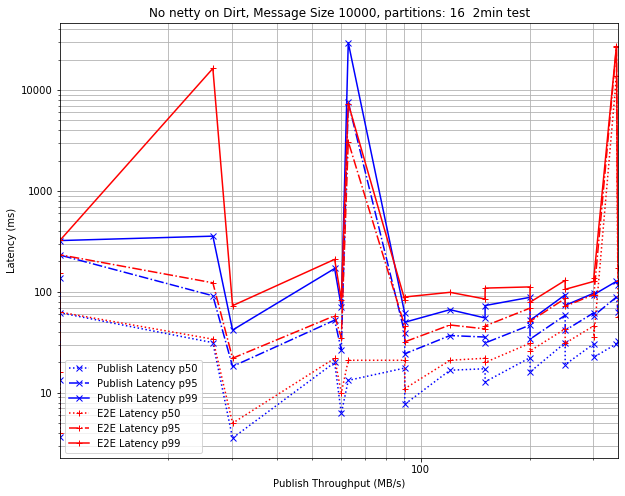

In [185]:
plot_latency_vs_throughput(filt_10000_df)

In [186]:
latency_vs_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
10.024086,3.683,13.329,138.236,4.000,16.000,154.000,be994611-de50-4562-b50b-90f5c5e6f12d
10.026675,62.060,231.297,322.343,63.000,233.000,325.001,e0cd840a-bbba-429f-8d3c-30c534a2b368
26.546444,31.399,91.535,356.501,34.000,123.000,16346.047,f7ca9b91-0f39-4754-9820-49535f0f8e60
30.095801,3.564,18.253,41.839,5.000,22.000,73.000,8ae94d37-9ab0-4cd2-be8e-61593c2f10b5
57.693137,19.999,52.481,170.454,22.000,58.000,210.000,9705a488-452c-40fa-8da4-ca544ab219dc
60.202691,6.250,26.540,70.900,10.000,35.000,84.000,a6393ac7-acfe-4bde-9806-be5fcd5e9bdc
62.923158,13.281,7544.255,29427.839,21.000,3088.015,7344.031,52b685ef-83a7-4b23-bd12-1723e34ca6ad
90.162248,17.582,39.145,61.527,21.000,46.000,84.000,1dbe84f1-bb57-4daf-af42-052069101e6e
90.228567,7.701,24.349,50.037,11.000,32.000,89.000,d57d4164-d19e-409b-ab80-61e6805782a4


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [187]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

4

In [188]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

,partitionsPerTopic,consumerPerSubscription,git_commit,pravegaVersion,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMs50Pct,publishLatencyMs99Pct,endToEndLatencyMs50Pct,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,,
0765ca66-a869-4b60-b457-9500ef5d8636,1,1,0f33554,0.8.0-2527.e480f26_no_netty_Dirt,810378.134191,81.037813,43.071,304.335,87464.447,143276.031,2020-04-28 18:20:41.396944+00:00
d6e64bdc-d6be-47c7-806f-efa7aaeb9180,1,1,0a3b238,0.8.0-2527.e480f26_better_batching_Dirt,974185.947085,97.418595,65.567,323.333,101456.383,151303.167,2020-04-28 13:32:49.308666+00:00
968a9d1a-a5d0-4456-b95c-699e3fda6355,16,16,0a3b238,0.8.0-2527.e480f26_better_batching_Dirt,990005.473438,99.000547,22.343,155.623,34432.255,155725.823,2020-04-28 13:36:00.031718+00:00
4425d8b6-f046-43dc-97bc-b3bbb2e9dbfd,16,16,0f33554,0.8.0-2527.e480f26_no_netty_Dirt,818307.050469,81.830705,16.043,192.664,41055.231,158302.207,2020-04-28 18:23:53.952226+00:00


# Analyze Latency Distribution

In [189]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

'0765ca66-a869-4b60-b457-9500ef5d8636'

In [190]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

In [191]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [192]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

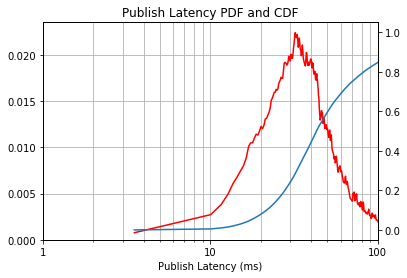

In [193]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [194]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

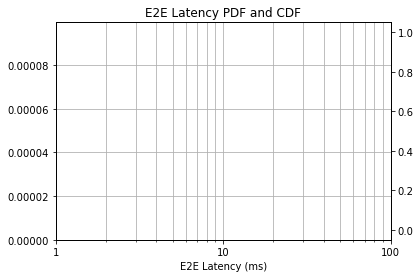

In [195]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

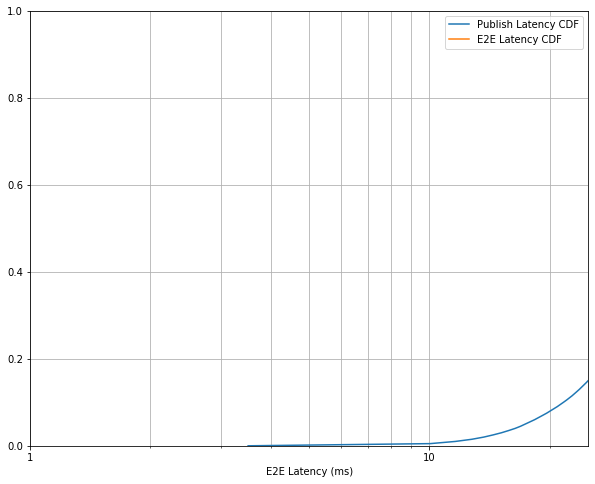

In [196]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [ ]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    driverName='Pravega',
    #numWorkloadWorkers=4, 
    topics=1,
    testDurationMinutes=2,
    size_of_test_batch=(2,1000), # between
    aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=100,
    #producersPerTopic=1,
    partitionsPerTopic=16,    
)
len(filt_df)
filt_df.iloc[0].pravegaVersion
#filt_df.iloc[2].pravegaVersion

In [ ]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.8.0-2527.e480f26_better_batching_Dirt',
)
len(filt1_df)

In [ ]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.8.0-2527.e480f26_no_netty_Dirt',
)
len(filt2_df)

In [ ]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

In [ ]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    title = 'No netty vs Better Batching on Dirt Message Size 10k, partitions: 16,  2min test'
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                title=title,
                color=color,
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [ ]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='Publish')

In [ ]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='EndToEnd')